In [1]:
import tensorflow as tf
import tensorflow_federated as tff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-04-23 22:18:51.172597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 22:18:51.199629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 22:18:51.200099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 22:18:51.723828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import collections
import time
from tqdm import tqdm

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
# from sklearn.externals.joblib import dump, load
from joblib import dump, load

In [3]:
NB_CLIENTS = 9
TEST_CLIENT = None
DATA_PATH_PATTERN = "../data/Device #%d.csv"
WHOLE_CLASSES = ['benign', 'm_scan', 'm_ack', 'm_syn', 'm_udp', 'm_udpplain', 'g_combo', 'g_junk', 'g_scan', 'g_tcp', 'g_udp']
BINARY_MODE = False
BATCH_SIZE = 64
NB_CLASSES = len(WHOLE_CLASSES)
NB_EPOCHES = 1
NB_ROUNDS = 10
MX_RECORDS = 200000

In [4]:
def preprocessor(_client_data: pd.DataFrame):
    cropped_data = shuffle(_client_data)
    
    def callback(row):
        pass
    
    _x = cropped_data.drop(["type"], axis=1)
    _y = cropped_data["type"]
    if BINARY_MODE:
        _y = (_y == "benign").astype(int)
    return _x, _y

In [5]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_dim = 116),
        tf.keras.layers.GroupNormalization(),
#         tf.keras.layers.BatchNormalization(synchronized=True, input_dim=116),
#         tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64),
        tf.keras.layers.LeakyReLU(alpha=0.05),
        tf.keras.layers.Dense(32),
        tf.keras.layers.LeakyReLU(alpha=0.05),
        tf.keras.layers.Dense(32),
        tf.keras.layers.LeakyReLU(alpha=0.05),
        tf.keras.layers.Dense(NB_CLASSES, activation = "softmax")
    ])
    return model

In [6]:
model = create_model()
model.compile(tf.keras.optimizers.RMSprop(), 'categorical_crossentropy', metrics=['acc'])

In [7]:
train_data = pd.read_csv(DATA_PATH_PATTERN % 1)
X, Y = preprocessor(train_data)

for idx in range(2, 10):
    _x, _y = preprocessor(pd.read_csv(DATA_PATH_PATTERN % idx))
    X = pd.concat([X, _x])
    Y = pd.concat([Y, _y])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 101)

In [9]:
#Use StandardScaler() to standardize data - explained in Honours Project
sc = StandardScaler()
sc.fit(np.array(x_train))
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

le = LabelEncoder()
le.fit(WHOLE_CLASSES)
y_train = le.transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test)

/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [10]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

2023-04-23 22:20:41.617721: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2459720144 exceeds 10% of free system memory.


Epoch 1/5
165661/165661 [==============================] - 142s 834us/step - loss: 0.1330 - acc: 0.9454 - val_loss: 0.1000 - val_acc: 0.9604
Epoch 2/5
165661/165661 [==============================] - 137s 828us/step - loss: 0.1118 - acc: 0.9580 - val_loss: 0.0852 - val_acc: 0.9667
Epoch 3/5
165661/165661 [==============================] - 137s 827us/step - loss: 0.1165 - acc: 0.9582 - val_loss: 0.1295 - val_acc: 0.9528
Epoch 4/5
165661/165661 [==============================] - 138s 833us/step - loss: 0.1152 - acc: 0.9604 - val_loss: 0.0932 - val_acc: 0.9625
Epoch 5/5
165661/165661 [==============================] - 139s 839us/step - loss: 0.1174 - acc: 0.9607 - val_loss: 0.0888 - val_acc: 0.9602


In [11]:
y_pred = model.predict(x_test)
roc_matrix = np.zeros([NB_CLASSES, NB_CLASSES])

for corr, pred in zip(y_test, y_pred):
    corr_idx = np.argmax(corr)
    pred_idx = np.argmax(pred)
    roc_matrix[pred_idx][corr_idx] += 1

41416/41416 [==============================] - 19s 459us/step


<Axes: >

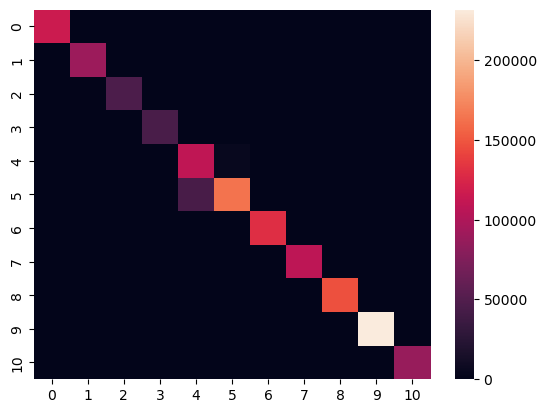

In [12]:
plt.figure()
sns.heatmap(roc_matrix)

In [13]:
model.save_weights("../models/dl.h5")

In [14]:
dump(sc, '../models/std_scaler.bin', compress=True)
dump(le, '../models/lab_encoder.bin', compress=True)

['../models/lab_encoder.bin']